In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [78]:
class BetaVAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=32, beta=4):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logvar = self.fc_logvar(result)
        return mu, logvar

    # workaround to make network differentiable
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 256, 16, 16)
        reconstruction = self.decoder(result)
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
#         print(f"BCE: {BCE}")
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#         print(f"KLD: {KLD}")
#         MSE = F.mse_loss(recon_x, x)
#         print(f"MSE: {MSE}")
#         SSIM = 
        return BCE + self.beta * KLD# + 1000*MSE

In [3]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
# Preprocess and load data into Dataloader

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path)#.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Set the directory containing images
# img_dir = '/kaggle/input/mri-data-resized/for_dlest_resized'
img_dir = '/kaggle/input/ixi-t1-axial-unlabelled-256x256/IXI_axial_mri_T1_unlabeled_256x256'

# transform simply converts the preprocessed images into tensors
# If not preprocessed, optionally you can resize and pad the images
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    # transforms.Pad((0, 0, 0, 0), fill=0, padding_mode='constant'),  # No-op padding, can customize if needed
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomImageDataset(img_dir=img_dir, transform=transform)

# # Create the DataLoader
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Create the training set and testing set
train_size = int(0.96 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, drop_last=True)

# Check shape of the batch
# for batch in dataloader:
for batch in train_loader:
    print(f"Batch size: {batch.size()}")  # should print [16, 3, 256, 256] assuming batch_size=16
#     print(batch[0][0][120][120].numpy())
    break

Batch size: torch.Size([8, 1, 256, 256])


In [81]:
# training function
def train_beta_vae(model, optimizer, scheduler, dataloader, epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        train_loss /= len(dataloader.dataset)
        scheduler.step(train_loss)
        
        print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

        
model = BetaVAE(in_channels=1, latent_dim=32, beta=4)

from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, verbose=True)

train_beta_vae(model, optimizer, scheduler, train_loader, epochs=1000)

Epoch 1, Loss: 35806.7955
Epoch 2, Loss: 26516.3319
Epoch 3, Loss: 26265.2096
Epoch 4, Loss: 26078.5450
Epoch 5, Loss: 25792.6525
Epoch 6, Loss: 25275.3108
Epoch 7, Loss: 25064.2783
Epoch 8, Loss: 24910.4618
Epoch 9, Loss: 24731.3687
Epoch 10, Loss: 24649.0547
Epoch 11, Loss: 24537.2283
Epoch 12, Loss: 24422.1968
Epoch 13, Loss: 24368.1483
Epoch 14, Loss: 24349.1263
Epoch 15, Loss: 24298.8752
Epoch 16, Loss: 24256.4218
Epoch 17, Loss: 24245.9693
Epoch 18, Loss: 24214.4695
Epoch 19, Loss: 24140.4539
Epoch 20, Loss: 24114.6236
Epoch 21, Loss: 24069.6023
Epoch 22, Loss: 24065.1753
Epoch 23, Loss: 24049.1295
Epoch 24, Loss: 24006.1023
Epoch 25, Loss: 23990.7102
Epoch 26, Loss: 23960.0869
Epoch 27, Loss: 23952.5513
Epoch 28, Loss: 23942.3155
Epoch 29, Loss: 23908.6985
Epoch 30, Loss: 23874.7164
Epoch 31, Loss: 23853.8912
Epoch 32, Loss: 23817.6011
Epoch 33, Loss: 23798.9690
Epoch 34, Loss: 23764.4782
Epoch 35, Loss: 23756.8360
Epoch 36, Loss: 23722.4214
Epoch 37, Loss: 23700.4533
Epoch 38, 

In [14]:
!pip install pytorch-msssim
# Import SSIM
from pytorch_msssim import ssim

torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


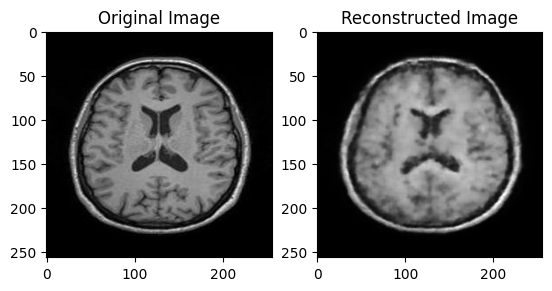

MSE: 0.007275932468473911
SSIM: 0.6780860424041748


In [83]:
# ONLY test the Autoencoder's reconstuction performance
import matplotlib.pyplot as plt
model.eval()

with torch.no_grad():
    for i, x in enumerate(test_loader):
        x = x.cuda()
        x_recon, _, _ = model(x)
#         print(x.shape)
#         print(x_recon.shape)
        # Plot original and reconstructed images
        if i == 0:
            img_index = 0
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(x[img_index].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[0].set_title("Original Image")
            axes[1].imshow(x_recon[img_index].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[1].set_title("Reconstructed Image")
            plt.show()
            print(f"MSE: {F.mse_loss(x_recon[img_index], x[img_index])}")
            print(f"SSIM: {ssim(x_recon[img_index].unsqueeze(1), x[img_index].unsqueeze(1), data_range=1, size_average=True)}")  # SSIM loss
        break